In [0]:
%pip install --upgrade typing_extensions
dbutils.library.restartPython()
import mlflow
import mlflow.tensorflow


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Databricks Notebook for Lung Disease Classification with MLflow
# 1️⃣ Install required libraries
%pip install tensorflow mlflow matplotlib

# 2️⃣ Imports
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import mlflow
import mlflow.tensorflow

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import mlflow
import mlflow.tensorflow

In [0]:
%pip install kaggle

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import json
import os

# Create a local folder for Kaggle config
kaggle_dir = "/tmp/kaggle"
os.makedirs(kaggle_dir, exist_ok=True)

# Save your kaggle.json there
kaggle_json = {
    "username": "khizraghaffar",
    "key": "<YPUR_API_KEY>"
}

with open(f"{kaggle_dir}/kaggle.json", "w") as f:
    json.dump(kaggle_json, f)

In [0]:
os.environ['KAGGLE_CONFIG_DIR'] = kaggle_dir

In [0]:
!kaggle datasets list

I0000 00:00:1760479182.907826    9401 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmadrazakashif/bmw-worldwide-sales-records-20102024          BMW Worldwide Sales Records (2010–2024)                853348  2025-09-20 14:39:45.280000           9049        193  1.0              
jockeroika/life-style-data                                    Life Style Data                                       3995645  2025-10-14 13:50:45.303000           3941         94  0.8235294        
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset  Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000           2834        103  1.0              
jaderz/hospital

In [0]:
# 3️⃣ Create a folder for the dataset
dataset_path = "/tmp/lung_data"
os.makedirs(dataset_path, exist_ok=True)

# 4️⃣ Download and unzip the Kaggle dataset
!kaggle datasets download -d fatemehmehrparvar/lung-disease -p {dataset_path} --unzip

I0000 00:00:1760479183.788254    9401 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


Dataset URL: https://www.kaggle.com/datasets/fatemehmehrparvar/lung-disease
License(s): Attribution 4.0 International (CC BY 4.0)
  0%|                                               | 0.00/34.9M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.9M/34.9M [00:00<00:00, 1.64GB/s]


In [0]:
import os

DATASET_PATH = "/tmp/lung_data"

for root, dirs, files in os.walk(DATASET_PATH):
    level = root.replace(DATASET_PATH, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files[:5]:  # only show first 5 files per folder
        print(f"{indent}    {f}")

lung_data/
    Lung X-Ray Image/
        Lung X-Ray Image/
            Lung_Opacity/
                471.jpg
                354.jpg
                888.jpg
                878.jpg
                243.jpg
            Normal/
                471.jpg
                354.jpg
                888.jpg
                878.jpg
                243.jpg
            Viral Pneumonia/
                471.jpg
                354.jpg
                888.jpg
                878.jpg
                243.jpg


In [0]:
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10

In [0]:
conv_filters = best_params['conv_filters']
dense_units = best_params['dense_units']
batch_size = best_params['batch_size']
learning_rate = best_params['learning_rate']

In [0]:
conv_filters = 64
dense_units = 256
batch_size = 16
learning_rate = 0.0007751617844442384

In [0]:
DATASET_PATH = "/tmp/lung_data/Lung X-Ray Image/Lung X-Ray Image"  # <- folder that contains NORMAL, PNEUMONIA, COVID

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 3475 files belonging to 3 classes.
Classes: ['Lung_Opacity', 'Normal', 'Viral Pneumonia']


2025-10-14 21:59:50.113743: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


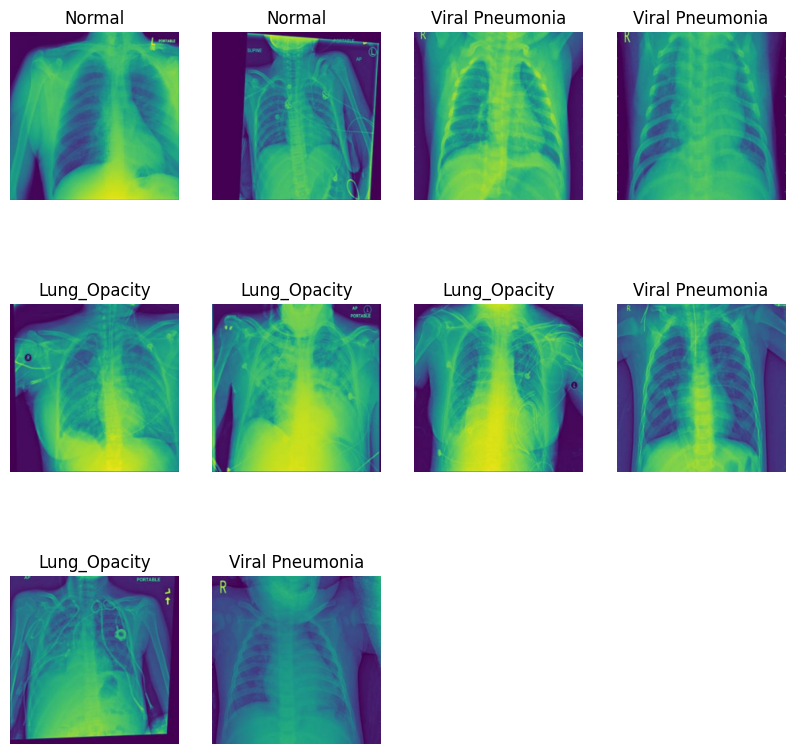

In [0]:
# Visualize some samples
plt.figure(figsize=(10,10))
for images, labels in dataset.take(1):
    for i in range(10):
        plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# 5️⃣ Split dataset
def preparing_Dataset(original_dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    dataset_length = len(original_dataset)
    if shuffle:
        ds = original_dataset.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * dataset_length)
    val_size = int(val_split * dataset_length)
    
    training_dataset = original_dataset.take(train_size)
    validation_dataset = original_dataset.skip(train_size).take(val_size)
    testing_dataset = original_dataset.skip(train_size).skip(val_size)
    
    return training_dataset, validation_dataset, testing_dataset

training_dataset, validation_dataset, testing_dataset = preparing_Dataset(dataset)

In [0]:
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_dataset = testing_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# 6️⃣ Preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

#### Model Training with Optimal Hyperparameters

In [0]:

# 7️⃣ Model definition
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
number_of_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(conv_filters, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(conv_filters, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(conv_filters, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(conv_filters, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(conv_filters, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(dense_units, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax'),
])

model.summary()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-48146759-a13b-4ffe-80c8-79af10e0e799/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [0]:

# 8️⃣ Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [0]:

# 9️⃣ MLflow tracking
mlflow.set_experiment("/Users/khizraghaffar3216@gmail.com/LungDiseaseClassificationTestingWith2Version")

with mlflow.start_run(run_name="LungDisease_CNN"):
    mlflow.tensorflow.autolog()  # Automatically log metrics, params, model
    
    # 10️⃣ Train model
    history = model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=EPOCHS,
        verbose=1
    )

2025/10/14 21:59:52 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_2' has no defined input shape yet.
2025-10-14 21:59:57.898752: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10


2025-10-14 22:00:04.877953: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 264257536 exceeds 10% of free system memory.
2025-10-14 22:00:05.313693: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 66064384 exceeds 10% of free system memory.
2025-10-14 22:00:05.416312: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 64000000 exceeds 10% of free system memory.
2025-10-14 22:00:06.296748: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 64000000 exceeds 10% of free system memory.
2025-10-14 22:00:06.500212: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 66064384 exceeds 10% of free system memory.


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6731 - loss: 0.7188

174/174 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.7554 - loss: 0.5784 - val_accuracy: 0.8393 - val_loss: 0.4638
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8117 - loss: 0.4541

174/174 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.8351 - loss: 0.4119 - val_accuracy: 0.8571 - val_loss: 0.3432
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8658 - loss: 0.3406

174/174 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.8592 - loss: 0.3494 - val_accuracy: 0.8780 - val_loss: 0.3156
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8701 - loss: 0.3445

174/174 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.8768 - loss: 0.3204 - val_accuracy: 0.8988 - val_loss: 0.2699
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.8854 - loss: 0.2961 - val_accuracy: 0.8899 - val_loss: 0.3014
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.8922 - loss: 0.2695 - val_accuracy: 0.8899 - val_loss: 0.2886
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.8983 - loss: 0.2501 - val_accuracy: 0.8929 - val_loss: 0.3198
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9199 - loss: 0.2096 - val_accuracy: 0.8988 - val_loss: 0.2907
Epoch 9/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9221 - loss: 0.1948 - val_accuracy: 0.8601 - val_loss: 0.3133
Epoch 10/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9281 - loss: 0.1862

174/174 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9346 - loss: 0.1731 - val_accuracy: 0.9018 - val_loss: 0.2561


2025-10-14 22:46:06.750404: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


2025/10/14 22:46:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


#### Model Performance with Test Dataset

In [0]:

# 11️⃣ Evaluate model
test_loss, test_accuracy = model.evaluate(testing_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
    
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_loss", test_loss)

23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 467ms/step - accuracy: 0.8845 - loss: 0.3244
Test Accuracy: 0.8845, Test Loss: 0.3244


In [0]:
!mlflow models serve -m "runs:/3186039220039096/model" -p 5000 --no-conda

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:465)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:741)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:80)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:348)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:59)
	at com.databricks.logging.AttributionContext$.withValue(Attr

### Local Model Serving

In [0]:
import requests
import json

url = "http://127.0.0.1:5000/invocations"
data = json.dumps({"instances": [[0.2, 0.5, 0.7, ...]]})
headers = {"Content-Type": "application/json"}

response = requests.post(url, data=data, headers=headers)
print(response.json())


### Schema Creation within Custom Catalog

In [0]:
%sql
-- Create a schema inside your catalog
CREATE SCHEMA IF NOT EXISTS khizra_catalog_ml.ml_models;


In [0]:
%sql
SHOW SCHEMAS IN khizra_catalog_ml;


### Model Serving

In [0]:
import numpy as np
import requests
import json

# Take a batch of images from your testing dataset
for images, labels in testing_dataset.take(1):  # take 1 batch
    first_image = images[0].numpy()
    first_label = labels[0].numpy()

    print("Actual class:", class_names[first_label])

    # Prepare image for JSON
    img_list = np.expand_dims(first_image, axis=0).tolist()  # shape: (1, 256, 256, 3)

    # Send request to Databricks Serving endpoint
    url = "https://dbc-6b041a36-5183.cloud.databricks.com/serving-endpoints/lung_disease_cnn_model_endpoint_ui/invocations"
    headers = {
        "Authorization": "Bearer <YOUR_DATABRICKS_ACCESS_TOKEN>",
        "Content-Type": "application/json"
    }
    data = json.dumps({"instances": img_list})

    response = requests.post(url, data=data, headers=headers)
    pred_probs = response.json()['predictions'][0]  # get first prediction

    # Get predicted class index
    pred_index = np.argmax(pred_probs)
    predicted_class = class_names[pred_index]

    print("Predicted class:", predicted_class)


Actual class: Viral Pneumonia
Predicted class: Viral Pneumonia
